In [1]:
from outbreak_data.authenticate_user import set_authentication
from outbreak_data import outbreak_data
import auth_token

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

matplotlib.rcParams['hatch.linewidth'] = 0.5

#### authenticate

In [3]:
set_authentication(auth_token.get_auth_token())

#### pull ww data

In [4]:
state = "Ohio"
state_id = 'USA_US-OH'
startdate, enddate = "2023-09-01", "2024-01-01"
ww_samples = outbreak_data.get_wastewater_samples(region=state, date_range=[startdate, enddate])
ww_samples = outbreak_data.get_wastewater_lineages(ww_samples)

https://dev.outbreak.info/wastewater_metadata/query?fetch_all=true&q=geo_loc_region:Ohio AND collection_date:[2023-09-01 TO 2024-01-01] AND demix_success:true
https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABKsfBZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=0
https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABKsfBZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=1


In [5]:
ww_samples['collection_date'] = pd.to_datetime(ww_samples['collection_date']) #in some pd versions, need to convert

In [6]:
ww_samples = outbreak_data.normalize_viral_loads_by_site(ww_samples)
ww_abundances = outbreak_data.datebin_and_agg(ww_samples, startdate=startdate, enddate=enddate, freq='7D')

#### pull clinical data

In [7]:
clinical_samples = outbreak_data.all_lineage_prevalences(location=state_id, other_threshold=0.0, nday_threshold=1, server='api.outbreak.info')

https://api.outbreak.info/genomics/prevalence-by-location-all-lineages?location_id=USA_US-OH&ndays=180&nday_threshold=1&other_threshold=0.0


In [8]:
clinical_samples = clinical_samples.rename(columns={'date': 'collection_date', 'lineage': 'name', 'prevalence': 'abundance'})
clinical_samples['normed_viral_load'] = 1
clinical_samples['ww_population'] = 1
clinical_samples['name'] = clinical_samples['name'].str.upper()
clinical_abundances = outbreak_data.datebin_and_agg(clinical_samples, startdate=startdate, enddate=enddate, freq='7D', loaded=False)

#### get the lineage tree

In [9]:
tree, lineage_key = outbreak_data.get_tree()

#### cluster lineages on average abundances

In [10]:
ww_abundance_data = ww_abundances.drop(columns=['viral_load']).mul(ww_abundances['viral_load'], axis=0).sum()
clinical_abundance_data = clinical_abundances.drop(columns=['viral_load', 'OTHER']).sum()
combined_abundances = (ww_abundance_data/ww_abundance_data.sum()).add(clinical_abundance_data/clinical_abundance_data.sum(), fill_value=0)
clusters = outbreak_data.cluster_lineages((tree, lineage_key), combined_abundances, n=10, alpha=0.5)

#### wastewater plots

In [11]:
def get_colors(lins, isnatural, lineage_key):
    colors = np.searchsorted(
        sorted([lin['alias'] for lin in lineage_key.values()]),
        [lineage_key[lin]['alias'] for lin in lins] )
    colors = colors ** 2
    colors = (colors - np.min(colors)) / (np.max(colors)-np.min(colors)) * 0.75
    return hsv_to_rgb([(color, 1, 0.333 + 0.333*b) for color, b in zip(colors, isnatural)])

def get_riverplot_baseline(clustered_abundances, n=128):
    c = clustered_abundances.drop(columns=['viral_load']) \
         .mul(clustered_abundances['viral_load'].interpolate(), axis=0).dropna()
    d = c.div(clustered_abundances['viral_load'].dropna(), axis=0)
    def shear(O):
        return (c.cumsum(axis=1).add(O, axis=0).rolling(window=2).apply(np.diff).mul(d)**2).sum().sum()
    Ot = -clustered_abundances['viral_load'].dropna()/2
    for n in range(128):
        O = np.random.normal(size=Ot.shape) / (n+48) * 2
        if shear(O+Ot) < shear(Ot):
            Ot += O
            Ot -= np.mean(Ot)
    return pd.Series(Ot, c.index).reindex(clustered_abundances.index).interpolate()

                                            other **  \
date_bin                                               
(2023-08-31 00:00:00, 2023-09-07 00:00:00]  0.017383   
(2023-09-07 00:00:00, 2023-09-14 00:00:00]  0.006113   
(2023-09-14 00:00:00, 2023-09-21 00:00:00]  0.038293   
(2023-09-21 00:00:00, 2023-09-28 00:00:00]  0.180883   
(2023-09-28 00:00:00, 2023-10-05 00:00:00]  0.036645   

                                                  B.1.1.529.2.86.1* (BA.2.86.1)  \
date_bin                                                                          
(2023-08-31 00:00:00, 2023-09-07 00:00:00]                              0.00000   
(2023-09-07 00:00:00, 2023-09-14 00:00:00]                              0.00000   
(2023-09-14 00:00:00, 2023-09-21 00:00:00]                              0.00000   
(2023-09-21 00:00:00, 2023-09-28 00:00:00]                              0.00002   
(2023-09-28 00:00:00, 2023-10-05 00:00:00]                              0.00003   

                         

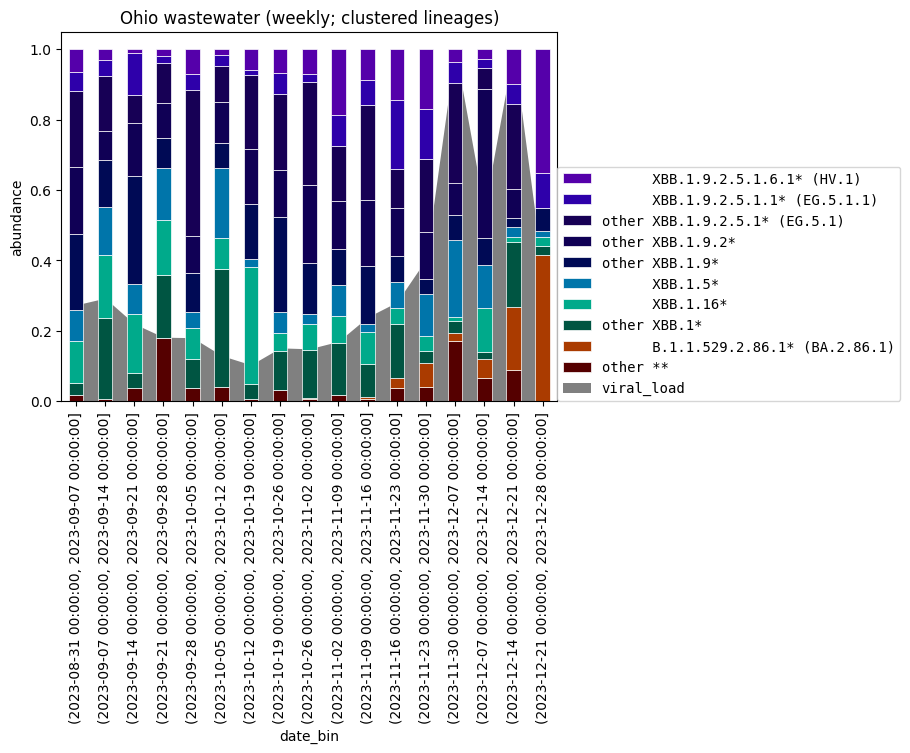

In [12]:
clustered_ww_abundances, root_lineages, isnatural = outbreak_data.cluster_df((tree, lineage_key), clusters, ww_abundances)
(clustered_ww_abundances['viral_load'] / clustered_ww_abundances['viral_load'].max()) \
    .interpolate().plot(kind='area', color='gray', linewidth=0)
colors = get_colors(root_lineages, isnatural, lineage_key)
clustered_ww_abundances.drop(columns=['viral_load']).plot(
    kind = 'bar', stacked = True, edgecolor = 'w', linewidth = .5, color = colors, ax=plt.gca() )
plt.ylabel('abundance')
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
plt.title(f'{state} wastewater (weekly; clustered lineages)')
print(clustered_ww_abundances.iloc[:5,:5])

Text(0.5, 1.0, 'Ohio wastewater (weekly; clustered lineages)')

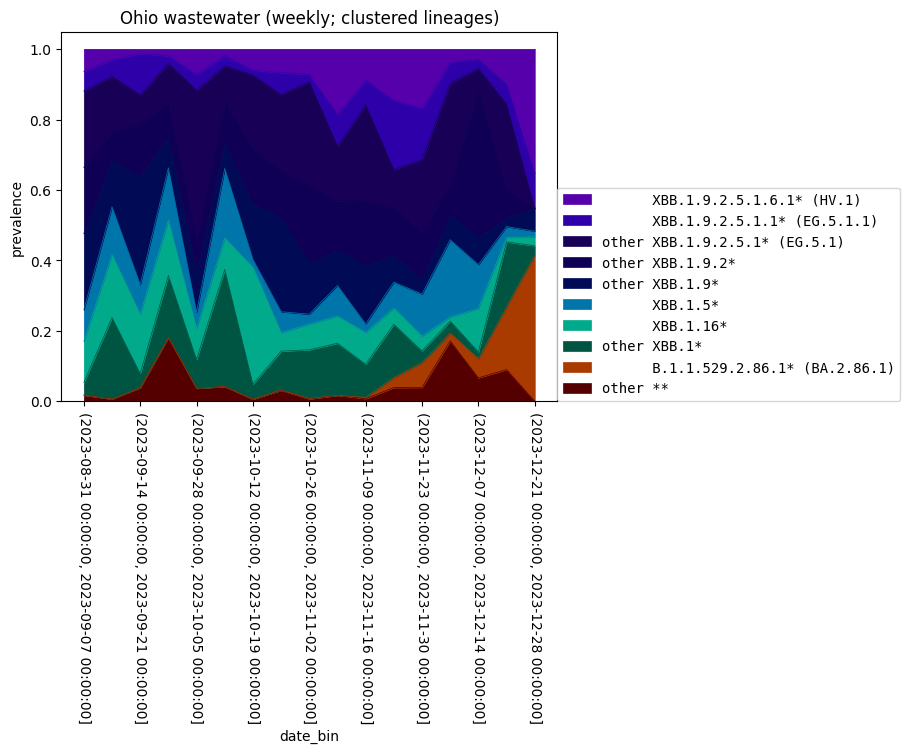

In [13]:
a = clustered_ww_abundances.drop(columns=['viral_load']).plot(kind='area', stacked=True, color=colors, linewidth=0.5)
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
plt.xticks(rotation=-90)
plt.ylabel('prevalence')
plt.title(f'{state} wastewater (weekly; clustered lineages)')

Text(0.5, 1.0, 'Ohio wastewater (weekly; clustered lineages)')

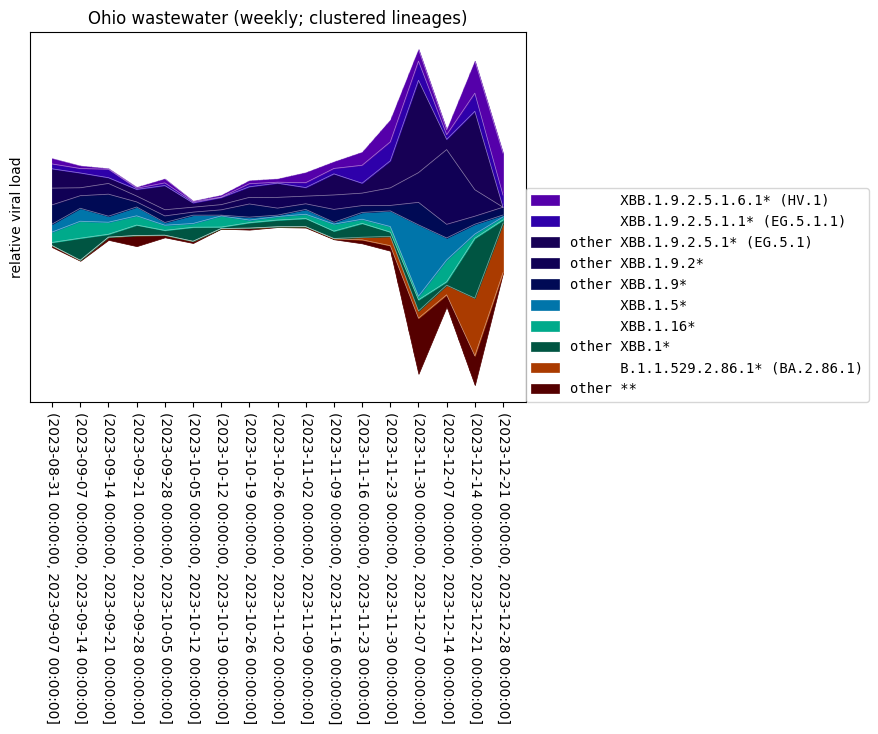

In [14]:
last_line = get_riverplot_baseline(clustered_ww_abundances)
for lin, color in zip(clustered_ww_abundances.drop(columns=['viral_load']).columns, colors):
    next_line = last_line + clustered_ww_abundances[lin] * clustered_ww_abundances['viral_load'].interpolate()
    plt.fill_between( clustered_ww_abundances[lin].index.astype(str), last_line.interpolate(), next_line.interpolate(),
                      color=list(color)+[0.25], edgecolor=color, linewidth=0, hatch='|||' )
    plt.plot(clustered_ww_abundances[lin].index.astype(str), next_line.interpolate(), color='white', linewidth=0.5, alpha=0.5)
    plt.fill_between( clustered_ww_abundances[lin].index.astype(str), last_line, next_line,
                      color=list(color), edgecolor=color, linewidth=0.5, label=lin )
    last_line = next_line
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
plt.xticks(rotation=-90)
plt.ylabel('relative viral load')
plt.yticks([])
plt.title(f'{state} wastewater (weekly; clustered lineages)')

#### clinical plots

Text(0.5, 1.0, 'Ohio clinical (weekly; clustered lineages)')

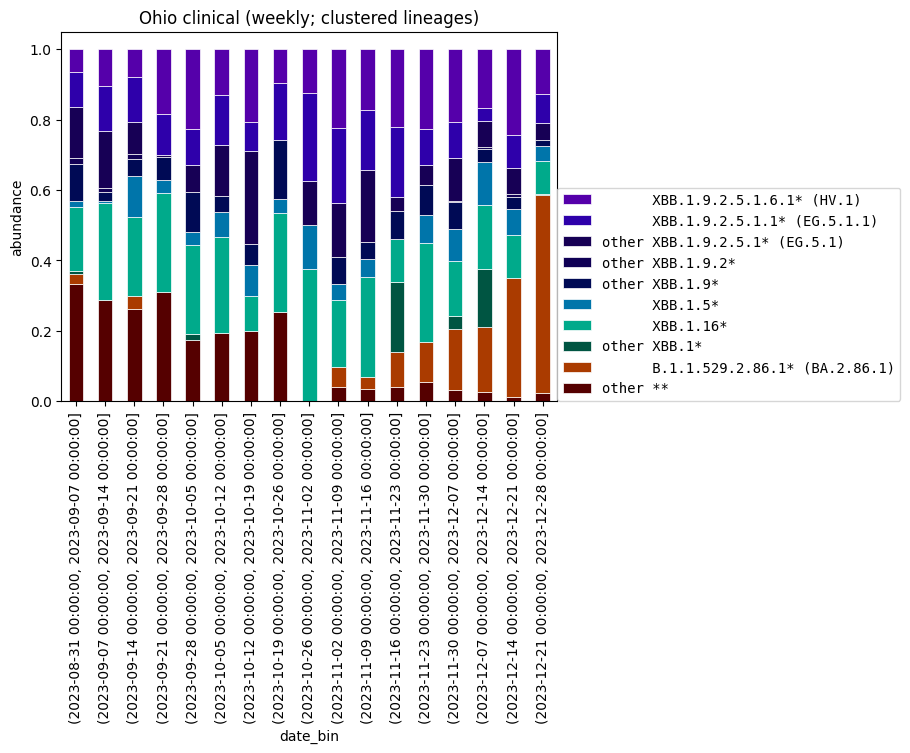

In [15]:
clustered_cl_abundances, root_lineages, isnatural = outbreak_data.cluster_df((tree, lineage_key), clusters, clinical_abundances)
clustered_cl_abundances['viral_load'] = ww_abundances['viral_load'].reindex(clustered_cl_abundances.index)
colors = get_colors(root_lineages, isnatural, lineage_key)
clustered_cl_abundances.drop(columns=['viral_load']).plot(
    kind = 'bar', stacked = True, edgecolor = 'w', linewidth = .5, color = colors, ax=plt.gca() )
plt.ylabel('abundance')
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
plt.title(f'{state} clinical (weekly; clustered lineages)')

Text(0.5, 1.0, 'Ohio clinical (weekly; clustered lineages)')

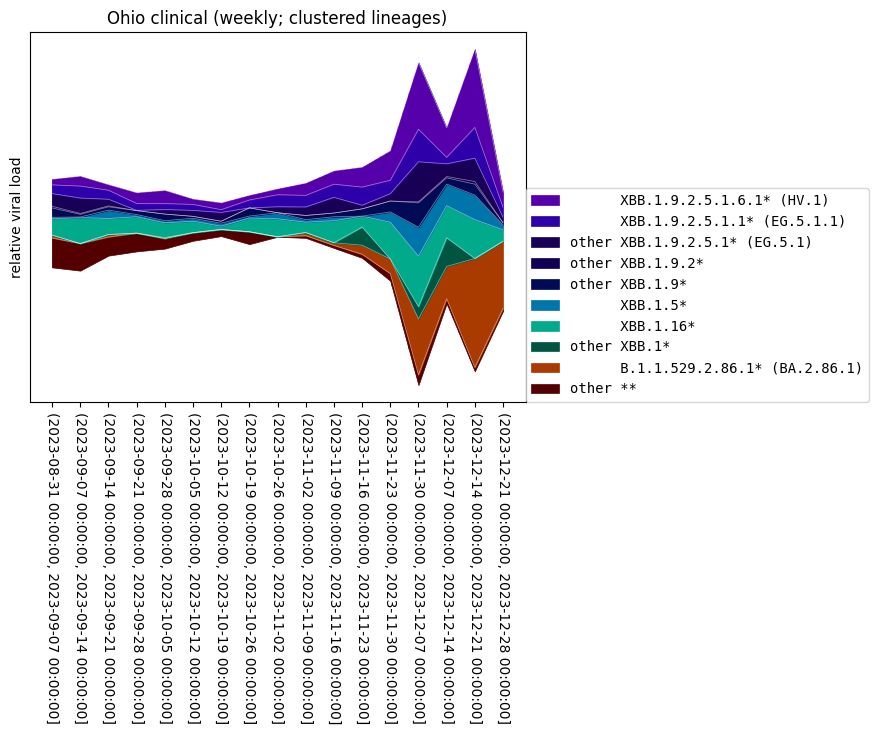

In [16]:
last_line = get_riverplot_baseline(clustered_cl_abundances)
for lin, color in zip(clustered_cl_abundances.drop(columns=['viral_load']).columns, colors):
    next_line = last_line + clustered_cl_abundances[lin] * clustered_cl_abundances['viral_load'].interpolate()
    plt.fill_between( clustered_cl_abundances[lin].index.astype(str), last_line.interpolate(), next_line.interpolate(),
                      color=list(color)+[0.25], edgecolor=color, linewidth=0, hatch='|||' )
    plt.plot(clustered_cl_abundances[lin].index.astype(str), next_line.interpolate(), color='white', linewidth=0.5, alpha=0.5)
    plt.fill_between( clustered_cl_abundances[lin].index.astype(str), last_line, next_line,
                      color=list(color), edgecolor=color, linewidth=0.5, label=lin )
    last_line = next_line
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
plt.xticks(rotation=-90)
plt.ylabel('relative viral load')
plt.yticks([])
plt.title(f'{state} clinical (weekly; clustered lineages)')

#### combined plot

In [17]:
groups = outbreak_data.gather_groups(clusters, combined_abundances)
clustered_abundances = pd.concat([clustered_ww_abundances, clustered_cl_abundances], keys=['A_wastewater', 'B_clinical'])
gcolors = [[colors[root_lineages.index(n['name'])] for n in g] for g in groups]
groups = [clustered_abundances[[clustered_abundances.columns[root_lineages.index(node['name'])] for node in group]].swaplevel(axis='rows').sort_index() for group in groups]
print(groups[0].head())

                                                         other XBB.1.9.2.5.1* (EG.5.1)  \
date_bin                                                                                 
(2023-08-31 00:00:00, 2023-09-07 00:00:00] A_wastewater                       0.217219   
                                           B_clinical                         0.143877   
(2023-09-07 00:00:00, 2023-09-14 00:00:00] A_wastewater                       0.155739   
                                           B_clinical                         0.163580   
(2023-09-14 00:00:00, 2023-09-21 00:00:00] A_wastewater                       0.080706   

                                                               XBB.1.9.2.5.1.1* (EG.5.1.1)  \
date_bin                                                                                     
(2023-08-31 00:00:00, 2023-09-07 00:00:00] A_wastewater                           0.054970   
                                           B_clinical                             0.098

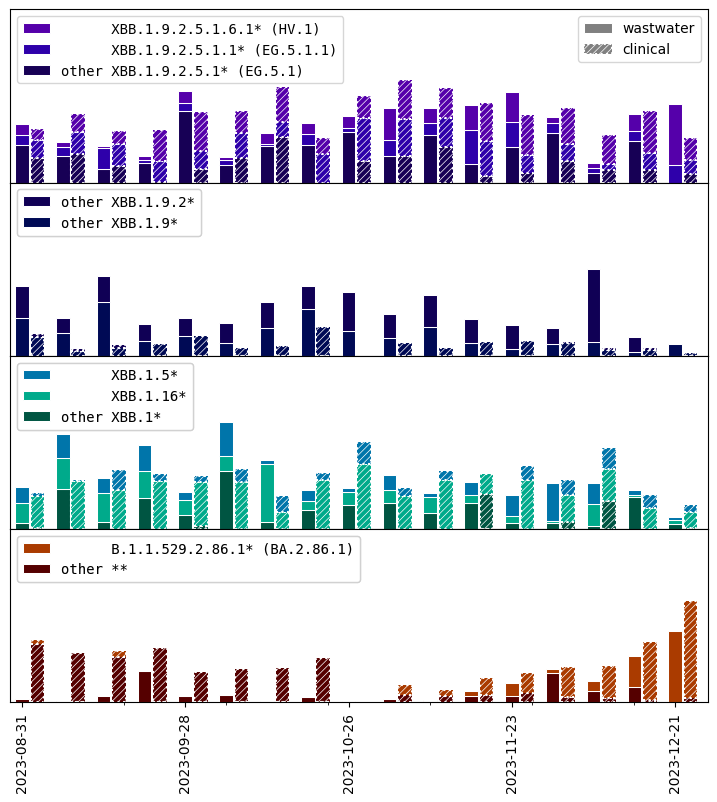

In [18]:
fig, axs = plt.subplots(len(groups),1, sharex=True, figsize=(9,9))
ax=None
for i, (ax, g, c) in enumerate(zip(axs, groups, gcolors)):
    ax.set_ylim(0,1)
    barstyle = {'linewidth': 0.75, 'edgecolor':'white'}
    cbarstyle = {'linewidth': 1.5, 'linestyle':':', 'hatch': '/////' }
    bars = g.plot(kind='bar', stacked=True, width=0.6667, color=c, ax=ax, **barstyle)
    for cbar in bars.patches[1::2]:
        cbar.set(**cbarstyle, x = cbar.get_x()-0.24)
    ax.add_artist(ax.legend(loc='upper left', prop={"family":"monospace"}, reverse=True))
    if i == 0: ax.legend([
            matplotlib.patches.Patch(facecolor='gray', **barstyle),
            matplotlib.patches.Patch(facecolor='gray', **(barstyle|cbarstyle))],
        ['wastwater', 'clinical'], loc='upper right')
    ax.set_yticks([])
get_date_formatter = lambda index: matplotlib.ticker.FuncFormatter(lambda x, pos: index[x//2].left.date())
ax.xaxis.set_major_formatter(get_date_formatter(clustered_ww_abundances.index.get_level_values(0)))
ax.set_xticks(np.arange(0, 2*len(clustered_ww_abundances.index)-1, 8))
ax.set_xlabel(None)
plt.subplots_adjust(wspace=0, hspace=0)